In [6]:
%load_ext autoreload
%autoreload 2
from cropd2p.cropdock.structure import atom_struct_2_seq, read_file_to_atomarray
from cropd2p.cropdock.run_msa import run_msa_mutil
import pandas as pd
from Bio.SeqRecord import SeqRecord
from cropd2p.cropdock.utils import select_core_structured_indices
from pathlib import Path
from cropd2p.cropdock.a3m import crop_a3m_file
from Bio.SeqRecord import SeqRecord
from utils.io_utils import read_fasta, write_fasta
from cropd2p.cropdock.utils import write_fasta as cropd2p_write_fasta
import numpy as np
from utils.io_utils import return_boltz_res_path_v2, load_boltz_json
from cropd2p.cropdock.parse_cropseq_resdct import read_iupred2_res

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
def process_complex_sequences(csv_path, out_path):
    save_path = out_path / 'seq'
    save_path_msa = out_path / 'msa'
    ppi_d = pd.read_csv(csv_path)
    # 确保目录存在
    save_path.mkdir(parents=True, exist_ok=True)
    save_path_msa.mkdir(parents=True, exist_ok=True)
    
    for row in ppi_d.itertuples():

        assembly_id = str(row.cif_id)
        pepid = row.protein_chain_id
        dnaid = row.dna_chain_id
        pep_seq = row.protein_sequence
        dna_seq = row.dna_sequence
        pep_seqr = SeqRecord(
            id=f'{assembly_id}_{pepid}_pep',
            seq=str(pep_seq)
        )
        dna_seqr = SeqRecord(
            id=f'{assembly_id}_{dnaid}_dna',
            seq=str(dna_seq)
        )
        save_path1 = save_path / f'{assembly_id}_{pepid}_{dnaid}'
        save_path1.mkdir(parents=True, exist_ok=True)
        cropd2p_write_fasta(str(pep_seqr.seq), save_path1 / f'{assembly_id}_{pepid}.fasta')
        cropd2p_write_fasta(str(dna_seqr.seq), save_path1 / f'{assembly_id}_{dnaid}.fasta')
            

In [49]:
# 解析dna和pep的序列
out_path = Path('./data/foldbench')
process_complex_sequences(csv_path=out_path / 'foldbench_pep_dna.csv', out_path=Path('./data/foldbench'))
fasta_dct = {}
for f in Path('./data/foldbench/seq').iterdir():
    pep_fasta_f = f.joinpath(f"{f.stem.split('_')[0]}_{f.stem.split('_')[-2]}.fasta")
    dna_fasta_f = f.joinpath(f"{f.stem.split('_')[0]}_{f.stem.split('_')[-1]}.fasta")
    fasta_dct[f.stem] = {
        'pep': pep_fasta_f,
        'dna': dna_fasta_f
    }

/home/zlab/miniconda3/envs/boltz1/lib/python3.10/site-packages/Bio/SeqRecord.py:228: BiopythonDeprecationWarning: Using a string as the sequence is deprecated and will raise a TypeError in future. It has been converted to a Seq object.
  warnings.warn(


In [50]:
fasta_dct

{'8yrs-assembly1_B_C': {'pep': PosixPath('data/foldbench/seq/8yrs-assembly1_B_C/8yrs-assembly1_B.fasta'),
  'dna': PosixPath('data/foldbench/seq/8yrs-assembly1_B_C/8yrs-assembly1_C.fasta')},
 '7un7-assembly1_A_T': {'pep': PosixPath('data/foldbench/seq/7un7-assembly1_A_T/7un7-assembly1_A.fasta'),
  'dna': PosixPath('data/foldbench/seq/7un7-assembly1_A_T/7un7-assembly1_T.fasta')},
 '8b9n-assembly1_A_B': {'pep': PosixPath('data/foldbench/seq/8b9n-assembly1_A_B/8b9n-assembly1_A.fasta'),
  'dna': PosixPath('data/foldbench/seq/8b9n-assembly1_A_B/8b9n-assembly1_B.fasta')},
 '9dp2-assembly1_A_D': {'pep': PosixPath('data/foldbench/seq/9dp2-assembly1_A_D/9dp2-assembly1_A.fasta'),
  'dna': PosixPath('data/foldbench/seq/9dp2-assembly1_A_D/9dp2-assembly1_D.fasta')},
 '8pmv-assembly1_A_B': {'pep': PosixPath('data/foldbench/seq/8pmv-assembly1_A_B/8pmv-assembly1_A.fasta'),
  'dna': PosixPath('data/foldbench/seq/8pmv-assembly1_A_B/8pmv-assembly1_B.fasta')},
 '8xas-assembly1_C_X': {'pep': PosixPath('dat

In [5]:
# 先生成msa
# run_msa_mutil(
#     fasta_files=fasta_files,
#     save_dir= Path('./data/foldbench/msa'),
#     n_cpu=30
# )

### 2. 计算无序区域 OR 计算结构化区域

In [27]:
from cropd2p.cropdock.crop_seq import run_dommap
from cropd2p.cropdock.parse_cropseq_resdct import get_domain_range

iupred2_dct =  read_iupred2_res(Path('iupred3_out'), 0.4)
# dommap_res = {}
# for fasta_file in fasta_dct.values():
#     fasta_file = fasta_file['pep']
#     print(fasta_file)
#     try:
#         run_dommap(fasta_file=fasta_file, output_file=Path(f'data/foldbench/dommap/{fasta_file.stem}.dommap'))
#         res = get_domain_range(Path(f'data/foldbench/dommap/{fasta_file.stem}.dommap'))
#         dommap_res[fasta_file.stem] = res[fasta_file.stem]
#     except:
#         print(fasta_file.stem)

In [ ]:
iupred2_dct 
def help_rename_inpred2(iupred2):
    iupred2_new = iupred2.split('_')
    if len(iupred2_new) > 3:
        str_s = iupred2_new[0] + '-' + iupred2_new[1] + '_' + iupred2_new[2] + '-' + iupred2_new[3]
    else:
        str_s = iupred2_new[0] + '-' + iupred2_new[1] + '_' + iupred2_new[2]
    return str_s
iupred2_dct = {help_rename_inpred2(i): v for i, v in iupred2_dct.items()}


###  crop msa

In [62]:
save_path_msa = Path('./data/foldbench/msa')
from Bio.Seq import Seq

def crop_seq(seq, intervals = None):
    return seq[int(intervals[0]): int(intervals[1])] if intervals else seq

crop_seqs_dct = {}


pep_dct = {i['pep'].stem: i['pep'] for k, i in fasta_dct.items()}
dna_dct = {i['pep'].stem: i['dna'] for k,i in fasta_dct.items()}


for id, intervals in iupred2_dct.items():
    intervals = None  # 这个是基线测试标准 baseline test
    crop_a3m_file(
        a3m_file=save_path_msa.joinpath(f'{id}/0.a3m'),
        interval=intervals,
        out_path=save_path_msa.joinpath(f'{id}/crop_iupred2_0.a3m'))
    seq = list(read_fasta(pep_dct[id]).values())[0]
    cs = crop_seq(
        seq       = seq,
        intervals = intervals
    )
    dna = list(read_fasta(dna_dct[id]).values())[0]
    fdna = str(Seq(dna).reverse_complement())
    crop_seqs_dct[id] = [cs, dna, fdna]

In [45]:
# seq_dct = {i:v[0] for i,v in crop_seqs_dct.items()}
# write_fasta('data/foldbench/foldench_pep.fasta', seq_dct)

In [64]:
### 3. 生成boltz input file
def to_boltz_input_file(
        id2seq,
        msa_dir,
        save_dir,
        crop_type):
    id2type = {
        'protein': 'A',
        'Fdna': 'B',
        'Rdna': 'C'
    }
    save_dir = save_dir / crop_type if crop_type else save_dir / 'fullseq'
    save_dir.mkdir(parents=True, exist_ok=True)
    for id, seq in id2seq.items():
        save_path = save_dir / f'{id}.fasta'
        msa_path = msa_dir / id / f'crop_{crop_type}_0.a3m' if crop_type else msa_dir / id / '0.a3m'
        pep_id = id2type['protein']
        dna1_id = id2type['Fdna']
        dna2_id = id2type['Rdna']
        pep  = seq[0]
        dna1 = seq[1]
        dna2 = seq[2]
        with open(save_path, 'w') as f:
            HEADER = f'{pep_id}|protein|{msa_path}'
            f.write(f'>{HEADER}\n')
            f.write(f'{pep}\n')
            HEADER = f'{dna1_id}|dna'
            f.write(f'>{HEADER}\n')
            f.write(f'{dna1}\n')
            HEADER = f'{dna2_id}|dna'
            f.write(f'>{HEADER}\n')
            f.write(f'{dna2}\n')

In [73]:
def help_load_res(pred_path):
    full_res_lst = {}
    full_json_dct = {}
    for i in Path(pred_path).iterdir():
        res = return_boltz_res_path_v2(
            boltz_path = i,
        )
        full_res_lst[i.stem] = res
        full_json_dct[i.stem] = load_boltz_json(res['json'])['iptm']
    return full_res_lst, full_json_dct

In [74]:
_, full_json_dct = help_load_res(pred_path=Path('data/foldbench/boltz_input/boltz_results_fullseq/predictions'))
_, crop_json_dct = help_load_res(pred_path=Path('data/foldbench/boltz_input/boltz_results_dommap/predictions'))
_, iupred2_json_dct = help_load_res(pred_path=Path('data/foldbench/boltz_input/boltz_results_iupred2/predictions'))

In [75]:
np.array(list(crop_json_dct.values())).mean()

0.8223758532650887

In [76]:
np.array(list(full_json_dct.values())).mean()

0.8561920233431363

In [77]:
np.array(list(iupred2_json_dct.values())).mean()

0.841593849775838

In [ ]:
df_crop = pd.DataFrame.from_dict(crop_json_dct, orient='index', columns=['ptm_crop'])
df_full = pd.DataFrame.from_dict(full_json_dct, orient='index', columns=['ptm_full'])
df_iupred2 = pd.DataFrame.from_dict(iupred2_json_dct, orient='index', columns=['ptm_iupred2'])

In [92]:
from cropd2p.cropdock.eval import calc_dockq

In [96]:
fasta_dct

{'8yrs-assembly1_B_C': {'pep': PosixPath('data/foldbench/seq/8yrs-assembly1_B_C/8yrs-assembly1_B.fasta'),
  'dna': PosixPath('data/foldbench/seq/8yrs-assembly1_B_C/8yrs-assembly1_C.fasta')},
 '7un7-assembly1_A_T': {'pep': PosixPath('data/foldbench/seq/7un7-assembly1_A_T/7un7-assembly1_A.fasta'),
  'dna': PosixPath('data/foldbench/seq/7un7-assembly1_A_T/7un7-assembly1_T.fasta')},
 '8b9n-assembly1_A_B': {'pep': PosixPath('data/foldbench/seq/8b9n-assembly1_A_B/8b9n-assembly1_A.fasta'),
  'dna': PosixPath('data/foldbench/seq/8b9n-assembly1_A_B/8b9n-assembly1_B.fasta')},
 '9dp2-assembly1_A_D': {'pep': PosixPath('data/foldbench/seq/9dp2-assembly1_A_D/9dp2-assembly1_A.fasta'),
  'dna': PosixPath('data/foldbench/seq/9dp2-assembly1_A_D/9dp2-assembly1_D.fasta')},
 '8pmv-assembly1_A_B': {'pep': PosixPath('data/foldbench/seq/8pmv-assembly1_A_B/8pmv-assembly1_A.fasta'),
  'dna': PosixPath('data/foldbench/seq/8pmv-assembly1_A_B/8pmv-assembly1_B.fasta')},
 '8xas-assembly1_C_X': {'pep': PosixPath('dat

In [93]:
calc_dockq()

TypeError: calc_dockq() missing 2 required positional arguments: 'pred_struct' and 'native_struct'

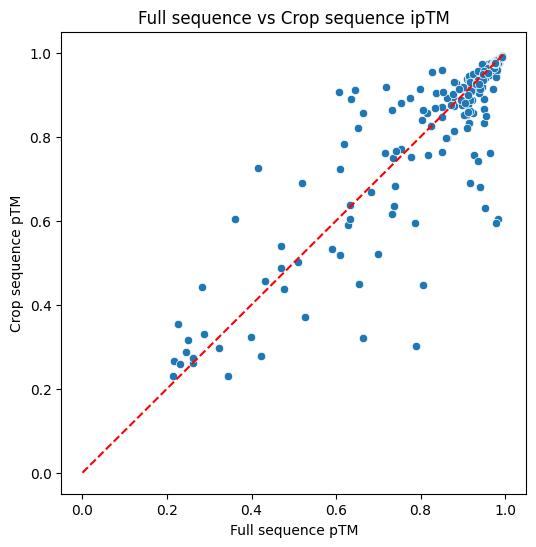

In [97]:
from seaborn import scatterplot
import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
scatterplot(data=df_full.join(df_iupred2), x='ptm_full', y='ptm_iupred2')
plt.plot([0,1], [0,1], color='red', linestyle='--')
plt.xlabel('Full sequence pTM')
plt.ylabel('Crop sequence pTM')
plt.title('Full sequence vs Crop sequence ipTM')
plt.show()

In [80]:
df_full

,ptm_full
7xvn-assembly1_A,0.936153
7prw-assembly1_B,0.802987
8oj6-assembly1_B,0.788501
9bdu-assembly1_B,0.912461
9dp2-assembly1_A,0.972731
...,...
9bvd-assembly1_C,0.958272
8g86-assembly1_E,0.632391
8j71-assembly1_A,0.913261
7uyp-assembly1_A-2,0.991898
